# Chapter 2. Multi-armed Bandits

## 2.1 A k-armed Bandit Problem
k개의 레버(k-armed)을 가진 빠찡코 기계(bandit)을 통해 게임을 할 때에 어떤 레버를 당겼을 때에 가장 많은 돈을 벌 수 있는 인공지능 프로그램(agent)를 만들어내는 문제. 단 아래의 몇 가지 제약 사항은 존재한다.
1. 각 레버의 당첨 확률을 고정(stationary)되어 있다
1. 당첨되는 경우와 그렇지 않은 경우 두 가지의 결과(reward)만 존재한다


### Approarch
1. k개의 레버에 대한 k가지의 선택(action)을 할 수 있고 많은 시도 끝에 특정 레버에 대한 보상이 더 좋다는 사실을 알 수 있다.
1. 이러한  반복적인 실험을 통해 특정한 레버의 가치(value)를 판단할 수 있고 함수로 표현할 수도 있다
1. 아래의 수식은 임의의 시점(t)에 임의의 행동(a)를 했을 때에 얻을 수 있는 실제 보상(Rt)을 아래와 같이 q\*로 표현한다.
$$q_*(a) \doteq E\begin{bmatrix}Rt|At=a\end{bmatrix}$$
1. 위의 q\*는 정확히 알기 어려우므로 반복적인 실험을 통해 예측된(estimated) Qt(a)를 구하고자 한다
1. 현재 지식으로 최선의 가치(reward)를 추구하는 **exploting**, 긴 미래를 생각해 탐험하는 것을 **exploring**이라 부른다

## 2.2 Action-value Methods


### Method One. <font color=orange>Epsilon Greedy Bandit</font> Method
<br>
#### References
1. __[datahubbs.com/multi_armed_bandits_part1](https://www.datahubbs.com/multi_armed_bandits_reinforcement_learning_1)__ 
2. __[Jupyter notebook cheatsheet](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)__
<br>
***
<br>
#### Lessons from mistakes
1. 결과가 자연스럽게 수렴하지 않고 계속 흔들리는 현상 : **average_rewards 변수를 episode loop 내부에 넣는 실수**
1. 결과가 실행마다 epsilon 결과의 순서가 바뀌는 현상 : **dict 킷값 없이 list 에 결과를 담아서 결과가 셔플되어 플롯되는 실수**
1. reward 차트가 서서히 증가하지 않고 출력되는 현상 : **object 생성 및 episode 진행 시에 reset 하지않아 발생하는 오류**

In [171]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
 
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

debug_flag = False

def debug(*args):
    if (debug_flag):
        print(list(args))
        
def info(*args):
    print(list(args))

In [ ]:
# python self.n 과 같이 scalar 값의 increment 시에는 반드시 self.n 으로 써야 하고, reference 객체는 o = self.o 와 같이 받아 써도 된다.
key = "foo"
class Foo:
    def __init__(self):
        self.n = 0
        self.dic = {}
    def update(self):
        print("update")
        n = self.n
        dic = self.dic
        n += 1
        dic[key] = dic.get(key, 0) + n
    def updateSelf(self):
        print("udpateSelf")
        self.n += 1
        self.dic[key] = self.dic.get(key, 0) + self.n
    def print(self):
        n = self.n
        dic = self.dic
        print('current n is {}'.format(n))
        for k, v in dic.items():
            print(k, v)
        print()

foo = Foo()
foo.print()

foo.update()
foo.print()

foo.updateSelf()
foo.print()

In [172]:
#### Figure 2.2. Average performance of "-greedy action-value methods on the 10-armed testbed.
class EgreedyBanditMethod:

    def __init__(self, k = 10, eps=0):
        self.k = k               # num of arms
        self.eps = eps       # epsilon
        self.n = 0             # step count
        self.m_r = 0         # mean reward
        self.k_n = np.zeros(k) # step count for every k
        self.k_r = np.zeros(k) #  reward for every k
        self.k_mu = np.random.normal(0, 1, k) # mu of every k
        
        info("{}({}, {}) called".format(EgreedyBanditMethod.__name__, k, eps))

    # eps 값에 따라서 0 ~ 10% 까지 not greedy action을 취한다.
    def getAction(self):
        prob = np.random.rand()
        action = 0
        if self.eps == 0 and self.n == 0:
            action = np.random.choice(self.k)
        elif prob < self.eps:
            action = np.random.choice(self.k)
        else:
            action = np.argmax(self.k_r)
        return action

    # 현재 action의 mu의 normal distribution unit variance 의 값을 reward로 반환한다
    def getReward(self, action):
        reward = np.random.normal(self.k_mu[action], 1)
        return reward

    # reward 값을 모델에 반영 - update 시에는 항상 self 로 접근하는 것이 안전함
    def updateModel(self, action, reward):
        self.n += 1
        self.k_n[action] += 1
        self.m_r += (reward - self.m_r) / self.n
        self.k_r[action] += (reward - self.k_r[action]) / self.k_n[action]
        return self.m_r
    
    def reset(self):
        self.n = 0             # step count
        self.m_r = 0         # mean reward
        self.k_n = np.zeros(self.k) # step count for every k
        self.k_r = np.zeros(self.k) #  reward for every k
        self.k_mu = np.random.normal(0, 1, self.k) # mu of every k

def plotChart(title, rewards, episodes):
    plt.figure(figsize=(12, 8))
    for key, reward in rewards.items():
        plt.plot(reward, label=key)
    plt.legend(bbox_to_anchor=(1.2, 0.5))
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.title("Average {} Rewards after {} Episodes".format(title, str(episodes)))
    plt.show()


In [179]:
def runEgreedy(num_of_episodes = 1000, num_of_steps = 1000):
    ebms = {
        "$\\epsilon=0.1$":EgreedyBanditMethod(eps=0.1), 
        "$\\epsilon=0.01$":EgreedyBanditMethod(eps=0.01),
        "$\\epsilon=0 (greedy)$":EgreedyBanditMethod(eps=0)
    }
    rwds = {}
    for key, ebm in ebms.items():
        average_rewards = np.zeros(num_of_steps)
        for episode in range(num_of_episodes):
            ebm.reset()
            rewards = np.zeros(num_of_steps)
            for step in range(num_of_steps):
                action = ebm.getAction()
                reward = ebm.getReward(action)
                mean_reward = ebm.updateModel(action, reward)
                debug(action, reward, mean_reward)
                rewards[step] = mean_reward
            average_rewards = average_rewards + (rewards - average_rewards) / (episode + 1)
        rwds[key] = average_rewards.copy()
    plotChart("$\epsilon-greedy$", rwds, num_of_episodes)

['EgreedyBanditMethod(10, 0.1) called']
['EgreedyBanditMethod(10, 0.01) called']
['EgreedyBanditMethod(10, 0) called']


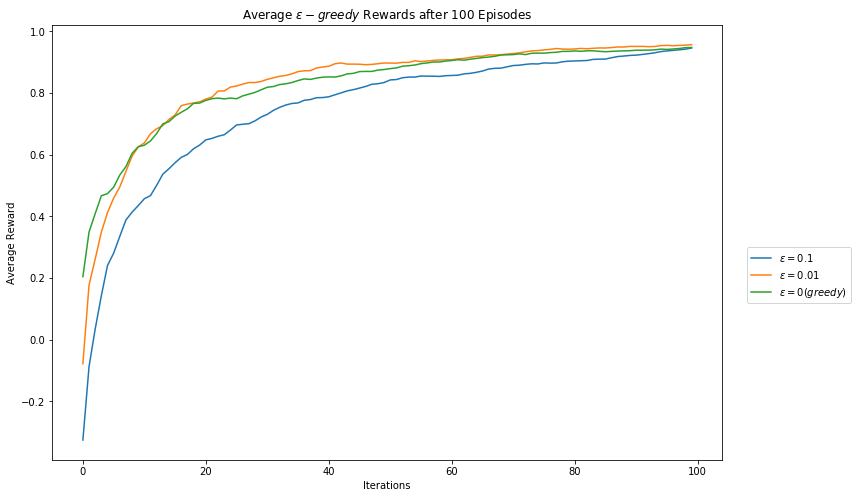

In [180]:
runEgreedy(100, 100)

['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0.1) called']
['EgreedyBanditMethod(10, 0.01) called']


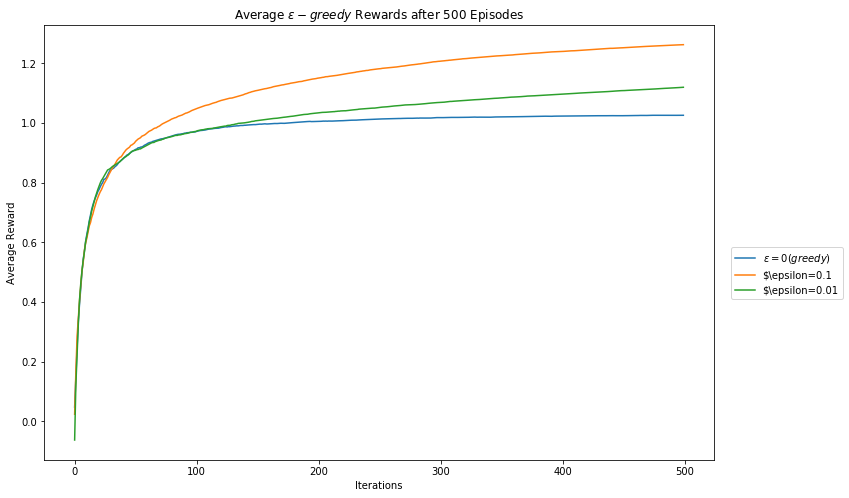

In [175]:
runEgreedy(500, 500)

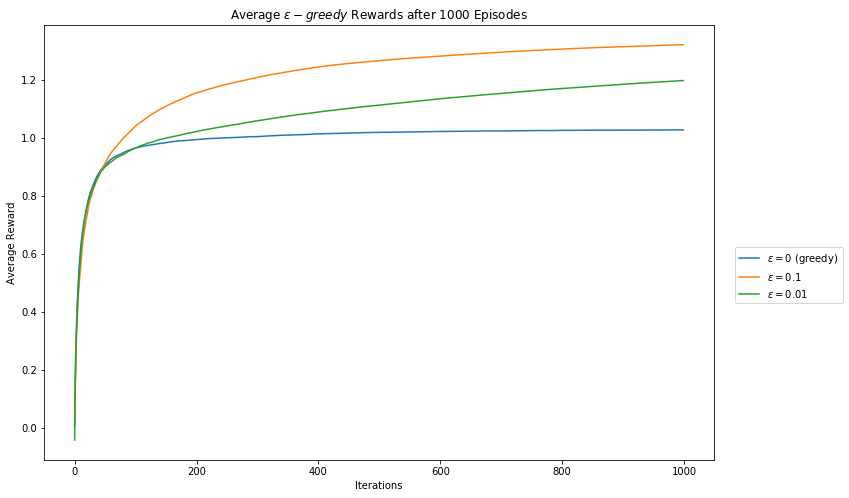

In [23]:
runEgreedy(1000, 1000)

<br>
<br>
### 2. Upper-Confidence-Bound Action Selection
<br>
#### References
1. __[datahubbs.com/multi_armed_bandits_part2](https://www.datahubbs.com/multi-armed-bandits-reinforcement-learning-2)__
2. __[Latex Mathmatics](https://en.wikibooks.org/wiki/LaTeX/Mathematics )__
<br>
$$A_t=\underset{a}{\operatorname{argmax}}\begin{bmatrix}Q_t(a) + c\sqrt{\log{t}/N_t(a)}\end{bmatrix},(2.10)$$

In [ ]:
class Parent:
    def __init__(self):
        print("{} init called".format(Parent.__name__))
    def getAction(self):
        print("parent get action")
    def getReward(self):
        print("parent get reward")
    
class Child(Parent):
    bar = { "foo":"bar" }
    def getAction(self):
        print("child get action - {}".format(self.bar["foo"]))
        
class Foo:
    bar = { "foo":"bar" }
    
child = Child()
child.getAction()
child.getReward()

foo = Foo()
print(foo.bar["foo"])

In [176]:
# EgreedyBanditMethod 클래스를 상속하고 getAction 메소드만 override 한다.
class UpperConfidenceBoundActionSelection(EgreedyBanditMethod):
    def __init__(self, k=10, eps=0, steps=1000, c=2):
        EgreedyBanditMethod.__init__(self, k, eps)
        self.steps = steps
        self.c = c
        self.uncertainty = np.zeros(steps)
        
    def getAction(self):
        action = 0
        if self.eps == 0 and self.n == 0:
            action = np.random.choice(self.k)
        else:
            action = np.argmax(self.k_r + self.c * np.sqrt(np.log(self.n) / self.k_n))
        return action

In [177]:
def runUCB(num_of_episodes = 1000, num_of_steps = 1000):
    ucbs = {
        "$\\alpha=1$" : UpperConfidenceBoundActionSelection(c=1),
        "$\\alpha=2$" : UpperConfidenceBoundActionSelection(c=2),
        "$\\alpha=4$" : UpperConfidenceBoundActionSelection(c=4) 
    }
    rwds = {}
    for key, ucb in ucbs.items():
        average_rewards = np.zeros(num_of_steps)
        for episode in range(num_of_episodes):
            ucb.reset()
            rewards = np.zeros(num_of_steps)
            for step in range(num_of_steps):
                action = ucb.getAction()
                reward = ucb.getReward(action)
                mean_reward = ucb.updateModel(action, reward)
                debug(action, reward, mean_reward)
                rewards[step] = mean_reward
            average_rewards = average_rewards + (rewards - average_rewards) / (episode + 1)
        rwds[key] = average_rewards.copy()
    plotChart("UCB Action Selection", rwds, num_of_episodes)

['EgreedyBanditMethod(10, 0) called']


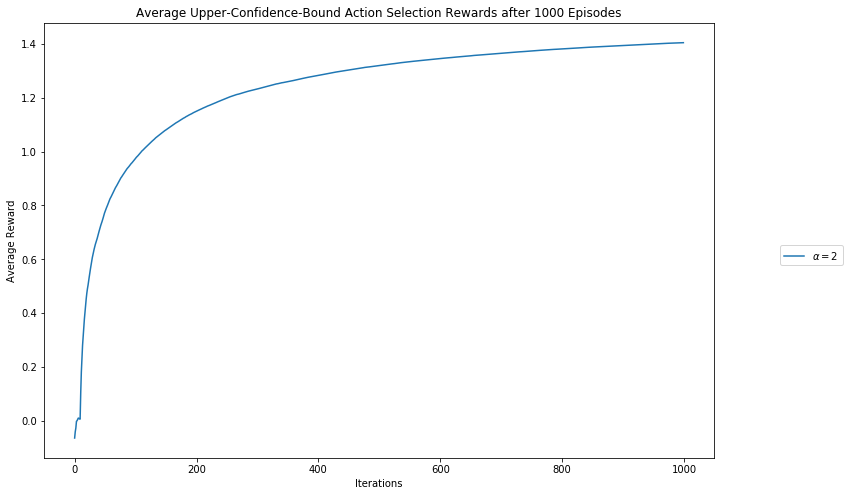

In [142]:
runUCB(1000, 1000)

['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']


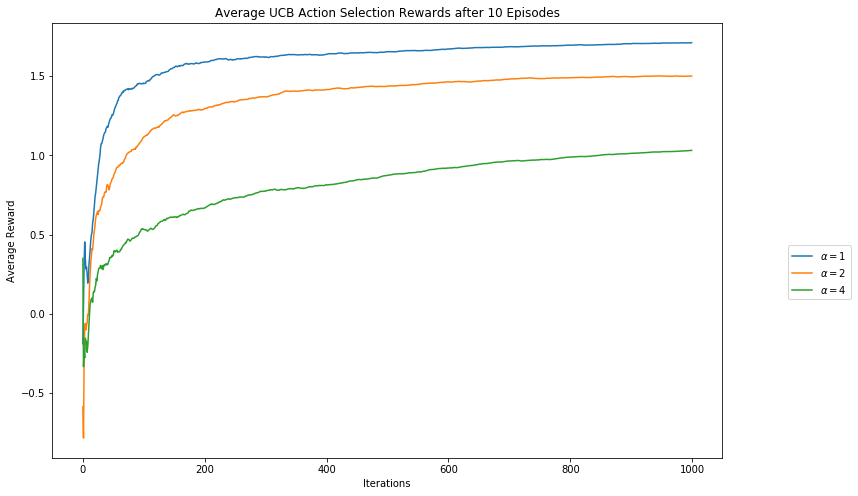

In [165]:
runUCB(1000, 1000)

<br>
### 3. Gradient Bandit Algorithms
<br>
#### References
1. __[datahubbs.com/multi_armed_bandits_part2](https://www.datahubbs.com/multi-armed-bandits-reinforcement-learning-2)__
<br>

In [214]:
class GradientBanditAlgorithms(EgreedyBanditMethod):
    def __init__(self, k=10, eps=0, steps=1000, alpha=0.4):
        EgreedyBanditMethod.__init__(self, k, eps)
        self.actions = np.arange(k)
        self.H = np.zeros(k) # preferences
        self.alpha = alpha # learning rate
        
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
        
    def getAction(self):
        self.softmax() # Update probabilities
        action = np.random.choice(self.actions, p=self.prob_action) # Select highest preference action
        return action
    
    def updateModel(self, action, reward):
        m_r = EgreedyBanditMethod.updateModel(self, action, reward)
        self.H[action] = self.H[action] + self.alpha * (reward - self.m_r) * (1 - self.prob_action[action]) # update preferences
        actions_not_taken = self.actions!=action
        self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.m_r) * self.prob_action[actions_not_taken]
        return m_r
    
    def reset(self):
        EgreedyBanditMethod.reset(self)
        self.H = np.zeros(self.k)


In [156]:
def runGBA(num_of_episodes = 1000, num_of_steps = 1000):
    gbas = {
        "$\\alpha=0.1$" : GradientBanditAlgorithms(alpha=0.1),
        "$\\alpha=0.4$" : GradientBanditAlgorithms(alpha=0.4),
        "$\\alpha=0.8$" : GradientBanditAlgorithms(alpha=0.8)
    }
    rwds = {}
    for key, gba in gbas.items():
        average_rewards = np.zeros(num_of_steps)
        for episode in range(num_of_episodes):
            gba.reset()
            rewards = np.zeros(num_of_steps)
            for step in range(num_of_steps):
                action = gba.getAction()
                reward = gba.getReward(action)
                mean_reward = gba.updateModel(action, reward)
                debug(action, reward, mean_reward)
                rewards[step] = mean_reward
            average_rewards = average_rewards + (rewards - average_rewards) / (episode + 1)
        rwds[key] = average_rewards.copy()
    plotChart("GBA Action Selection", rwds, num_of_episodes)

['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']


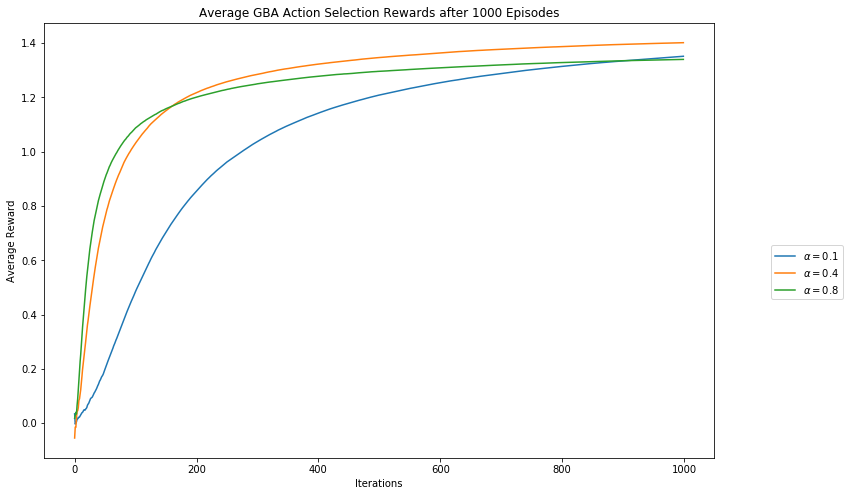

In [157]:
runGBA(1000, 1000)

<br>
### 4. Comparison Various Bandit Algorithms
1. e-greedy bandit method
2. upper confidence bound method
3. grdient bandit method
<br>

In [170]:
def runAll(num_of_episodes = 1000, num_of_steps = 1000):
    methods = {
        "$\\alpha=1 (Upper Confidence)$" : UpperConfidenceBoundActionSelection(c=1),
        "$\\epsilon=0.1 (Epsilon Greedy)$" : EgreedyBanditMethod(eps=0.1), 
        "$\\alpha=0.4 (Gradient Bandit)$" : GradientBanditAlgorithms(alpha=0.4)
    }
    rwds = {}
    for key, method in methods.items():
        average_rewards = np.zeros(num_of_steps)
        for episode in range(num_of_episodes):
            method.reset()
            rewards = np.zeros(num_of_steps)
            for step in range(num_of_steps):
                action = method.getAction()
                reward = method.getReward(action)
                mean_reward = method.updateModel(action, reward)
                debug(action, reward, mean_reward)
                rewards[step] = mean_reward
            average_rewards = average_rewards + (rewards - average_rewards) / (episode + 1)
        rwds[key] = average_rewards.copy()
    plotChart("$\epsilon$-Greedy, UCB and GBA methods", rwds, num_of_episodes)

['EgreedyBanditMethod(10, 0.1) called']
['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']


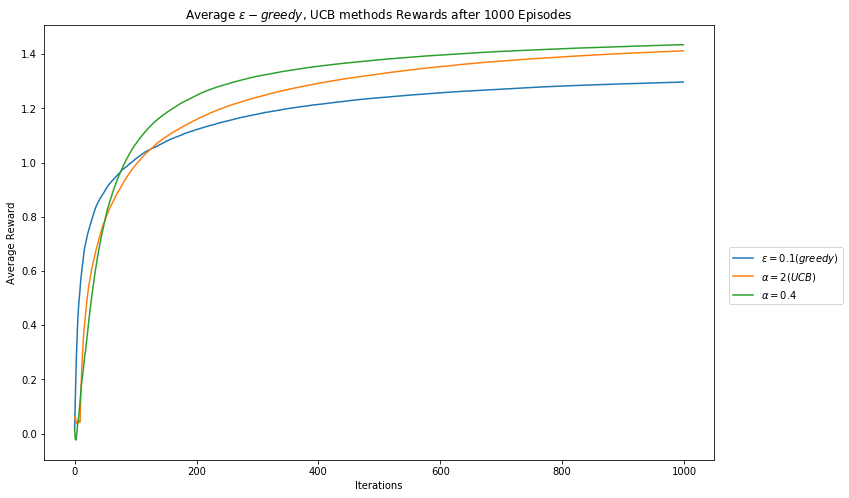

In [160]:
runAll(1000, 1000)

['EgreedyBanditMethod(10, 0.1) called']
['EgreedyBanditMethod(10, 0) called']
['EgreedyBanditMethod(10, 0) called']


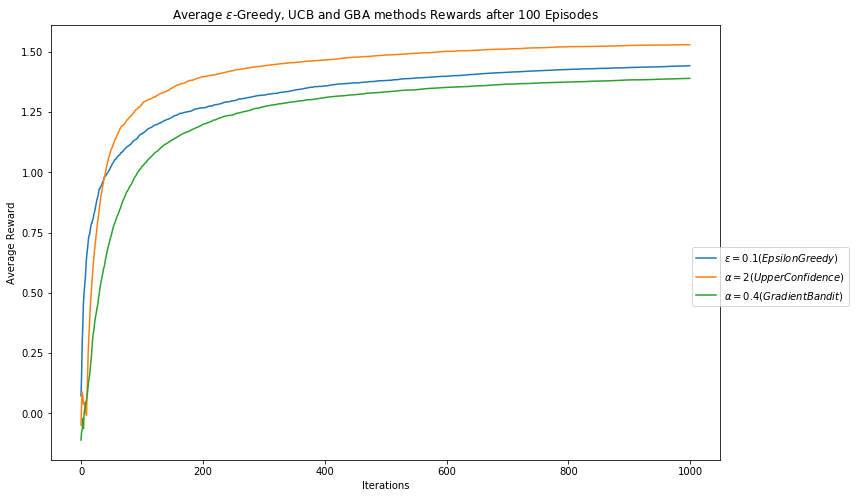

In [169]:
runAll(1000, 1000)

##### 더 해보고 싶은 것들
1. 알고리즘 혹은 메소드 별로 exploration vs exploitation 수행 빈도의 balance를 표로 나타내면 어떨까?
2. runXXX 함수들도 공통되는 부분을 제거하고 main 함수에서 methods 들만 넘겨주는 방식으로 리팩토링

### 5. Testing Softmax function and etc
#### References
1. [draw_bandits@yoonforrh](http://localhost:8888/notebooks/reinforcement2e/chapter2/chapter2_yoonforh.ipynb)

In [201]:
import matplotlib.pyplot as plt
import numpy as np

def draw_bandits(q_stars, r_dist) :
    k = len(q_stars)
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    # plot violin plot
    ax.violinplot(r_dist,
                showmeans=False,
                showmedians=True,
                showextrema=False,
                widths=0.3)

    # ax.set_title('Figure 2.1')
    ax.set_xticks([t + 1 for t in range(k)])
    ax.set_xticklabels([t + 1 for t in range(k)])
    for t in range(k) :
        ax.text(t + 1, q_stars[t], 'q*(' + str(t + 1) + ')')

    ax.set_xlabel('Action')
    ax.set_ylabel('Reward distribution')

    ax.plot([0.5, 10.5], [0, 0], linestyle='--', linewidth=1)
    plt.show()


In [ ]:
import pickle as pk
np.random.seed(9999) # Fixing random state for reproducibility
k = 10
q_stars = [ np.random.normal() for a in range(k) ]
r_dist = [np.random.normal(q_stars[t], 1.0, 2000) for t in range(k)]
# save generated bandit
pk.dump((q_stars, r_dist), open('10-armed.p', "wb" ))
draw_bandits(H, prob_action)

In [213]:
k=10
H = np.random.normal(0, 1, k)
prob_action = np.exp(H - np.max(H)) / np.sum(np.exp(H - np.max(H)), axis=0)
print(np.random.normal())
print(H)
print(prob_action)
print(sum(prob_action))

action = 0
reward = 1.0
alpha = 1.0
m_r = 0
actions = np.arange(k)
actions_not_taken = actions!=action
H[actions_not_taken] = H[actions_not_taken] - alpha * (reward - m_r) * prob_action[actions_not_taken]
print(actions_not_taken)

0.2979110754837141
[ 0.2039274  -0.47562422  1.04225611 -1.11366402  0.28640283 -0.4427535
 -0.70725563 -0.01460771  0.63021235  1.72687504]
[ 0.07680551  0.03892843  0.17761266  0.02056694  0.08340863  0.0402293
  0.03087953  0.06172823  0.11763203  0.35220875]
1.0
[False  True  True  True  True  True  True  True  True  True]
